# Exploratory Data Analysis

In this notebook, we will be importing the data and conducting EDA to evaluate our most pertinent features.

***

# Initialization

Importing libraries and setting seeds.

In [1]:
# Setting PYTHONHASHSEED
import os

pyhashseed1 = os.environ.get('PYTHONHASHSEED')
os.environ['PYTHONHASHSEED'] = '0'
pyhashseed2 = os.environ.get('PYTHONHASHSEED')

# NOTEBOOK EXCLUSIVE CODE
if __name__ == "__main__":
    print('Make sure the following says \'None\': ', pyhashseed1)
    print('Make sure the following says \'0\': ', pyhashseed2)

Make sure the following says 'None':  None
Make sure the following says '0':  0


In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

# Setting seed
np.random.seed(42)

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / 'plots'

def save_fig(fig_name, tight_layout=True, fig_extension='png', resolution=300):
    '''Saves an image to the plots folder with the specified name.'''
    path = IMAGES_PATH / f'{fig_name}.{fig_extension}'
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
def plt_show(plt_name):
    '''Saves an image using save_fig() under the plt_name and displays it.'''
    save_fig(plt_name)
    plt.show()

In [5]:
# Importing data
adclicks = pd.read_csv('data/ad_click_dataset.csv')

***

# Overview of data structure

We will be examining the data and its underlying structure

In [6]:
# Examining the top 10 rows
adclicks.head(10)

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0
5,5942,User5942,NaN,Non-Binary,NaN,Bottom,Social Media,Evening,1
6,7808,User7808,26.0,Female,Desktop,Top,NaN,NaN,1
7,5065,User5065,40.0,Male,Mobile,Side,NaN,Evening,0
8,7993,User7993,NaN,Non-Binary,Mobile,Bottom,Social Media,NaN,1
9,4509,User4509,NaN,NaN,NaN,Bottom,Education,Afternoon,1


In [ ]:
# NOTEBOOK EXCLUSIVE CODE
if __name__ == "__main__":

    # Checking duplicates
    duplicates = adclicks.duplicated()
    print(len(adclicks[duplicates]))
    
# Dropping duplicates
adclicks = adclicks.drop_duplicates()

2853

In [8]:
# NOTEBOOK EXCLUSIVE CODE
if __name__ == "__main__":
    
    # Information on features
    adclicks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7147 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7147 non-null   int64  
 1   full_name         7147 non-null   object 
 2   age               3671 non-null   float64
 3   gender            3747 non-null   object 
 4   device_type       5419 non-null   object 
 5   ad_position       5404 non-null   object 
 6   browsing_history  3667 non-null   object 
 7   time_of_day       5435 non-null   object 
 8   click             7147 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 558.4+ KB


Above, we can see that there are quite a bit of missing information (NaNs) and we also had to remove a significant amount of duplicate data.

A summary of `adclicks.info()`:

- There are 7,147 instances.
- `age`, `gender`, `device_type`, `ad_position`, `browsing_history`, and `time_of_day` have missing values.
- Most of the features are non-numeric, possibly categorical.
- `full_name` seems to be an irrelevant feature, as all the names are anonymized. I will remove this feature.
    - I will also check if `id` is a unique identifier, if so, I will drop it as use rowID as an identifier instead.

In [9]:
# NOTEBOOK EXCLUSIVE CODE
if __name__ == "__main__":
    
    # The number of unique IDs
    print(adclicks['id'].nunique())

4000


Since `id` is not unique for all rows, we will keep it and keep in mind this fact when we split our test set.

In [ ]:
# Dropping `full_name`
adclicks = adclicks.drop(columns='full_name')

***

## Examining categorical features

Let's examine what the possible values our non-numerical features have.

In [11]:
def categorical_features(df):
    '''Returns a list of the names of the cateogorical columns in a pandas dataframe.'''
    return list(df.select_dtypes(include=['object', 'category', 'bool']).columns)

In [12]:
# Possible values of the categorical features
categoricals = categorical_features(adclicks)

# NOTEBOOK EXCLUSIVE CODE
if __name__ == "__main__":
    
    # Check the columns in categoricals
    display(categoricals)

    # Display the unique values for each categorical feature
    for feature in categoricals:
        print(f'{feature}: ' ,list(adclicks[feature].unique()))

['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']

gender:  [nan, 'Male', 'Non-Binary', 'Female']
device_type:  ['Desktop', nan, 'Mobile', 'Tablet']
ad_position:  ['Top', 'Side', nan, 'Bottom']
browsing_history:  ['Shopping', nan, 'Education', 'Entertainment', 'Social Media', 'News']
time_of_day:  ['Afternoon', nan, 'Night', 'Evening', 'Morning']


Each categorical feature represents the following:

- `gender`: the gender of the user (Male, Female, Non-Binary).
- `device_type`: the type of device of the user when viewing the ad (Mobile, Desktop, Tablet).
- `ad_position`: the position of the ad on the webpage (Top, Side, Bottom).
- `browsing_history`: the user's browsing activity prior to seeing the ad (Shopping, News, Entertainment, Education, Social Media).
- `time_of_day`: the time when the user viewed the ad (Morning, Afternoon, Evening, Night).

Our numerical features represent the following:

- `id`: unique ID for each user (NOT EACH ROW).
    - This is important to note as we want to be aware of this when we split our test set in order to avoid data leakage.
- `age`: the age of each user.
- `click`: the **target label** indicating whether the user clicked on the ad (Binary).

***

# Splitting an initial training set for EDA + transformations

We will be splitting an initial training set to evaluate for EDA and assess what the necessary transformations will be.

In [20]:
# Splitting a random train-test set
from sklearn.model_selection import train_test_split
X = adclicks.drop(columns='click')
y = adclicks['click']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

***

# Pre-split EDA

We will perform some light EDA before we split to understand the overall pattern of the data and how it compares to our training data.

In [21]:
# NOTEBOOK EXCLUSIVE CODE
if __name__ == "__main__":
    
    # Display value counts for categorical features
    print('VALUE COUNTS OF CATEGORICAL FEATURES')
    for category in categoricals:
        display(X_train[category].value_counts())
        
    # Description statistics
    print('\nDESCRIPTION STATISTICS')
    display(X_train.describe())

VALUE COUNTS OF CATEGORICAL FEATURES


gender
Female        1035
Male          1015
Non-Binary     955
Name: count, dtype: int64

device_type
Mobile     1463
Desktop    1458
Tablet     1424
Name: count, dtype: int64

ad_position
Bottom    1478
Side      1435
Top       1400
Name: count, dtype: int64

browsing_history
Entertainment    635
News             584
Education        576
Social Media     573
Shopping         557
Name: count, dtype: int64

time_of_day
Morning      1146
Afternoon    1085
Night        1074
Evening      1054
Name: count, dtype: int64


DESCRIPTION STATISTICS


,id,age
count,5717.000000,2941.000000
mean,5029.128214,40.377763
std,2864.127895,13.130316
min,5.000000,18.000000
25%,2483.000000,29.000000
50%,5110.000000,40.000000
75%,7445.000000,52.000000
max,10000.000000,64.000000


5367


/var/folders/vd/7yzb859x5958jxfslq9bq57r0000gn/T/ipykernel_1307/3468805568.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


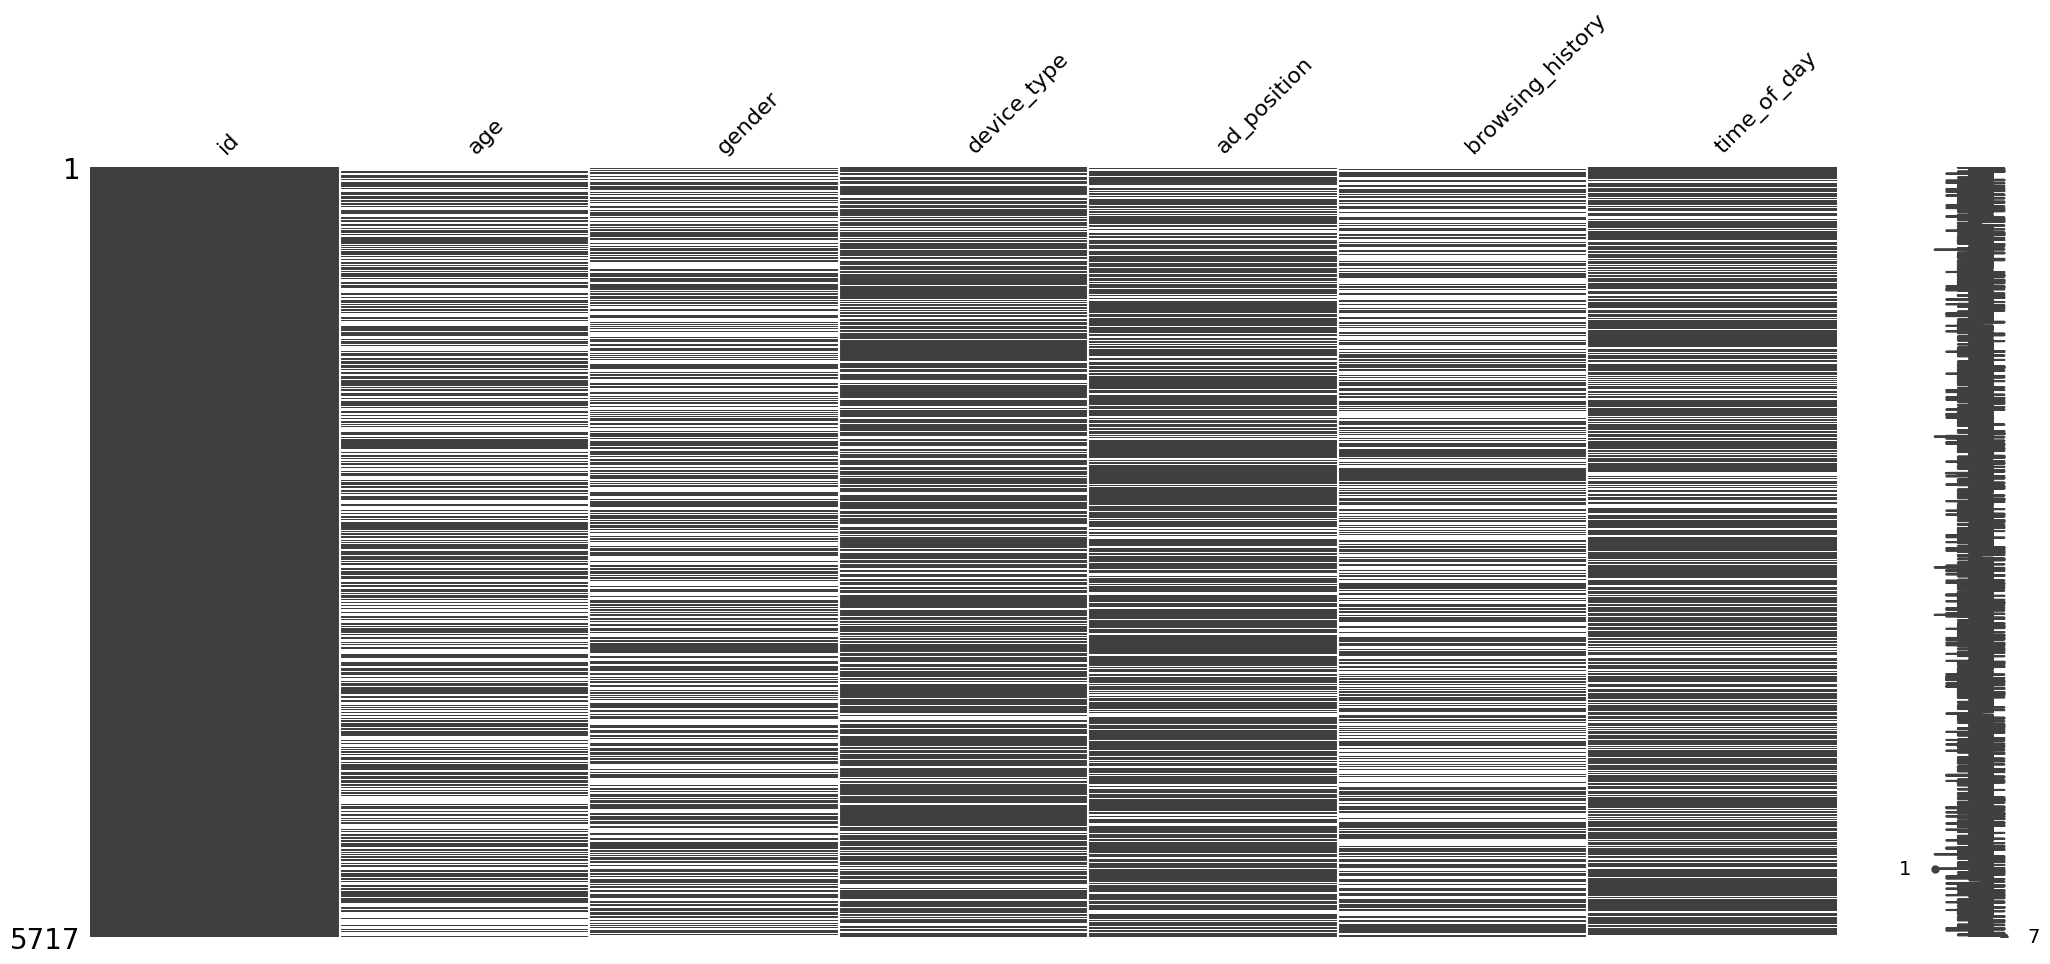

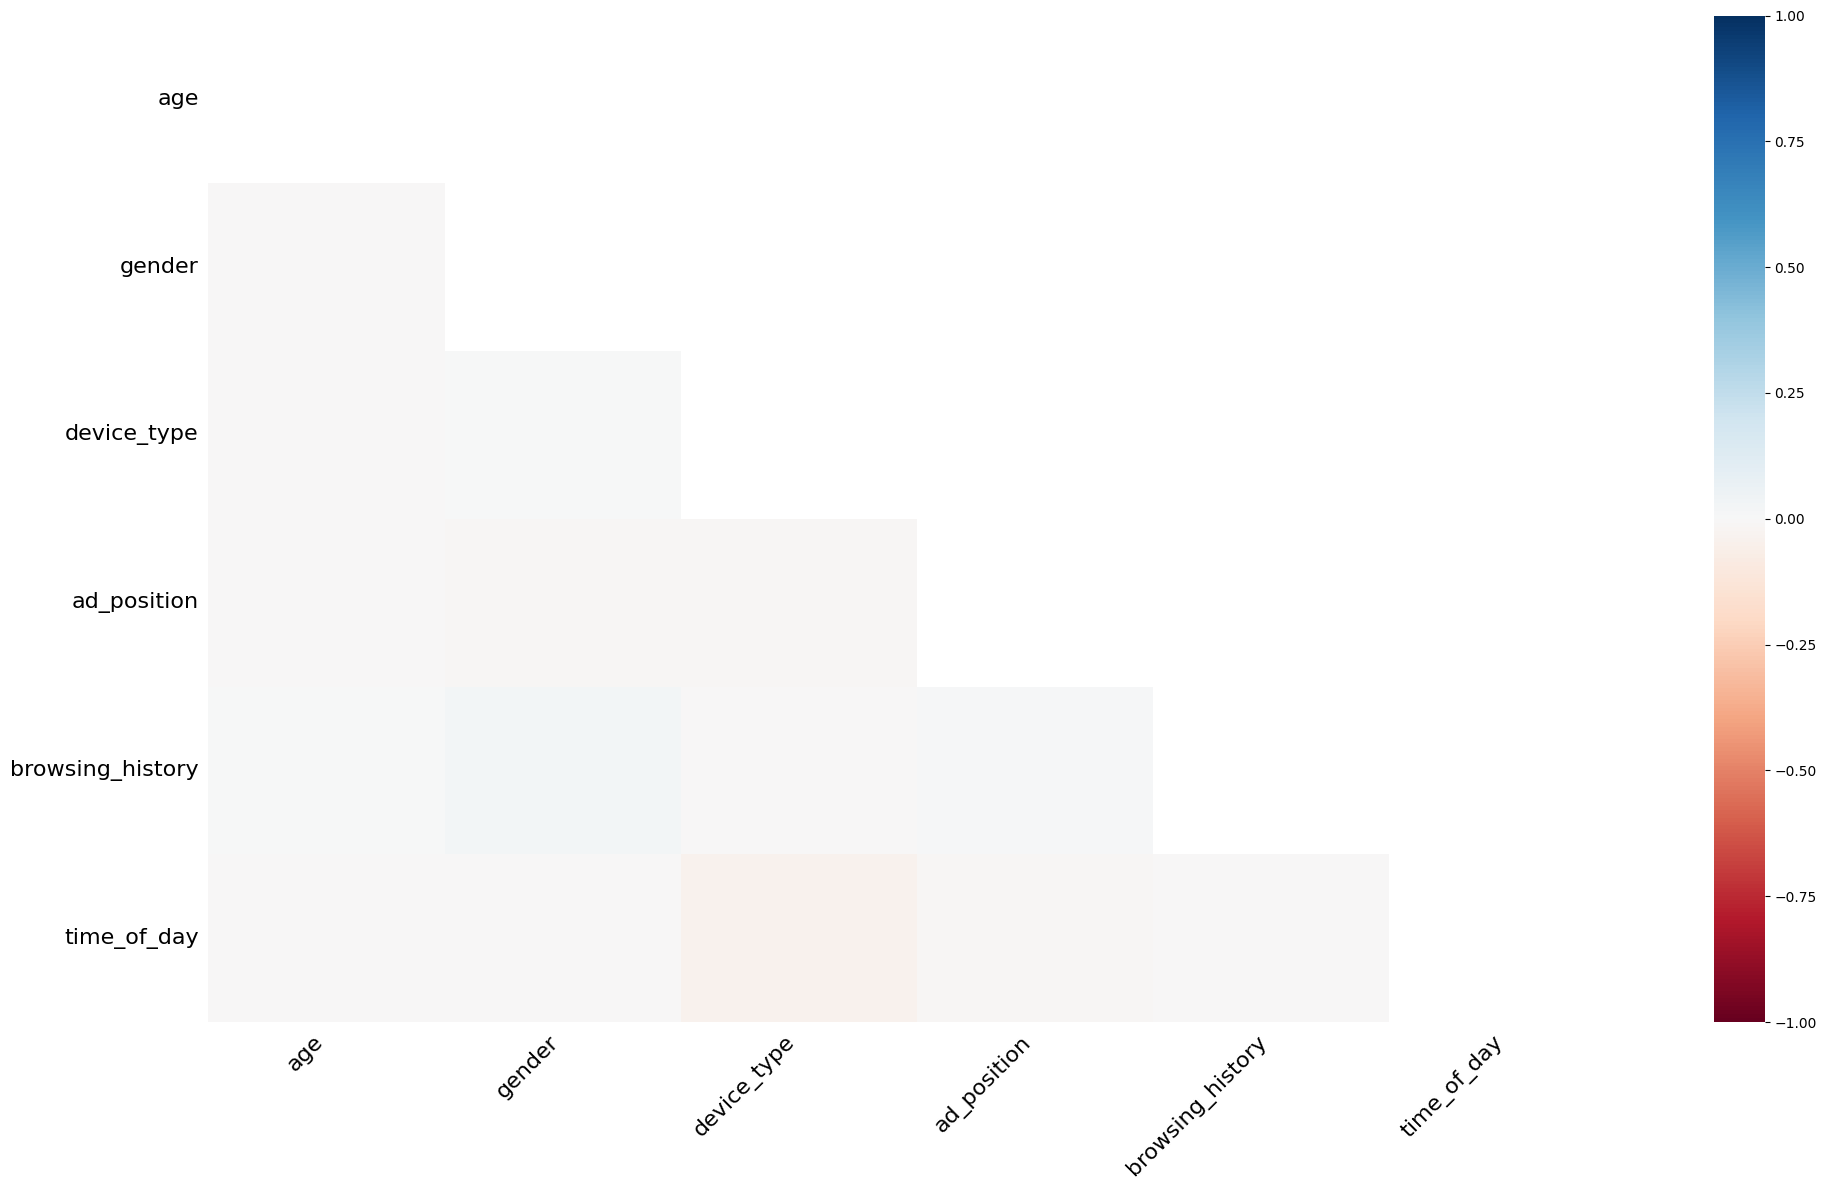

In [22]:
import missingno as msno

# NOTEBOOK EXCLUSIVE CODE
if __name__ == "__main__":
    
    # Evaluate missing data
    missing_values = X_train[X_train.isnull().any(axis=1)]
    print(len(missing_values))
    
    # Show the missing matrix
    msno.matrix(X_train)
    plt_show('missing_matrix')
    
    # Show the nullity correlation heatmap
    msno.heatmap(X_train)
    plt_show('nullity_corr_heatmap')

From a small look at our data, the following can be observed:

- The classes of each categorical feature are balanced
- The average age is 40 years old, and the data seems to not be skewed as the median also aligns with this value
- Most of the instances have missing data, which will significantly affect our modeling.
    - Luckily, the data shows to be missing at random (MAR), based on the sporadic pattern of the missing matrix and the neutral nullity correlation heatmap, so we can be optimistic about not running into issues during imputation of missing values.

***

# Splitting the test set

Considering that our target variable `click` is categorical, I am thinking that a **stratified-split** would be the best way to split our training and test data in order to represent our classes well. We will also have to split based on `id` to ensure that the same user is not in both the training and test set.

First, I want to see if we have any class imbalances in the `id` column.

In [23]:
# NOTEBOOK EXCLUSIVE CODE
if __name__ == "__main__":
    
    # Check the balance of user id
    max_appearance = adclicks['id'].value_counts().max()
    display(max_appearance)

14

The most that any user appears is 14 times, which is not bad news for our splitting. We will proceed!

In [24]:
# Splitting our data
from sklearn.model_selection import StratifiedGroupKFold

X = adclicks.drop(columns=['click']).copy()
y = adclicks['click'].copy()
groups = adclicks['id']

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=False)
# Setting shuffle to false so that the indices stay consistent in the split
splits = []

for train_index, test_index in sgkf.split(X, y, groups=groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    splits.append((X_train, X_test, y_train, y_test))

In [25]:
# NOTEBOOK EXCLUSIVE CODE
if __name__ == "__main__":
    
    # Checking that our split is sound
    for split, i in zip(splits, range(0, len(splits))):
        (X_train, X_test, y_train, y_test) = split
        
        train_users = set(X_train['id'])
        test_users = set(X_test['id'])
        
        # Printing output
        print(f'No overlap in train and test users in split {i + 1}:', train_users.isdisjoint(test_users))
        
        print('Train label values:')
        print(y_train.unique())
        print('Test label values:')
        print(y_test.unique(), '\n')

No overlap in train and test users in split 1: True
Train label values:
[1 0]
Test label values:
[1 0] 

No overlap in train and test users in split 2: True
Train label values:
[1 0]
Test label values:
[0 1] 

No overlap in train and test users in split 3: True
Train label values:
[1 0]
Test label values:
[1 0] 

No overlap in train and test users in split 4: True
Train label values:
[1 0]
Test label values:
[1 0] 

No overlap in train and test users in split 5: True
Train label values:
[1 0]
Test label values:
[1 0] 



Great! We have no overlap in our test and train users and our train and test sets both have representation of our target variable `click`. Just as a precaution for when we implement our models later, I am going to calculate the "sample weight" of each user ID in the data (below).

In [26]:
# Calculating sample weight in the training data
from sklearn.utils.class_weight import compute_sample_weight

for split in splits:
    train_set = split[0]
    train_set.loc[:, 'sample_weight'] = compute_sample_weight(class_weight='balanced', 
                                                            y=train_set['id'])

# NOTEBOOK EXCLUSIVE CODE
if __name__ == "__main__":
    # Display for the first split
    display(splits[0][0].head())

/var/folders/vd/7yzb859x5958jxfslq9bq57r0000gn/T/ipykernel_1307/3546069392.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.loc[:, 'sample_weight'] = compute_sample_weight(class_weight='balanced',
/var/folders/vd/7yzb859x5958jxfslq9bq57r0000gn/T/ipykernel_1307/3546069392.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.loc[:, 'sample_weight'] = compute_sample_weight(class_weight='balanced',
/var/folders/vd/7yzb859x5958jxfslq9bq57r0000gn/T/ipykernel_1307/3546069392.py:6: SettingWith

,id,age,gender,device_type,ad_position,browsing_history,time_of_day,sample_weight
0,670,22.0,NaN,Desktop,Top,Shopping,Afternoon,0.223320
1,3044,NaN,Male,Desktop,Top,NaN,NaN,0.255223
2,5912,41.0,Non-Binary,NaN,Side,Education,Night,0.223320
3,5418,34.0,Male,NaN,NaN,Entertainment,Evening,0.178656
4,9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,1.786563


***

# Next steps

Now, with successfully split data, we will move on to transforming and preprocessing. While EDA would usually occur during this time, since we split our training data into multiple splits, there's a chance that evaluating each split would result in data leakage. In order to avoid this, we will just proceed and apply any imputations that were fit to the original random training set that we split for EDA.